In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ewtpy
from Core2dsp.PLOT_Jiayu import plot
from NRSR_Tutorial.dsp import sine_wave

In [2]:
def ewt(signal, N, show=False):
    ewt_res, mfb ,boundaries = ewtpy.EWT1D(signal, N = N, detect='locmax', reg = 'average', lengthFilter = 50, sigmaFilter = 5, completion=1)
    if show:
        for res_out in ewt_res.T:
            plot(res_out, show=True)
    return ewt_res, mfb ,boundaries

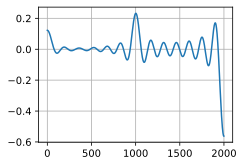

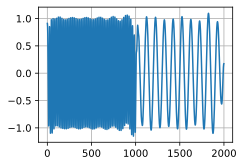

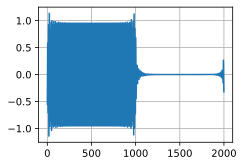

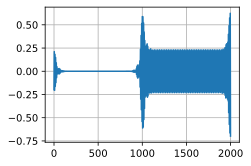

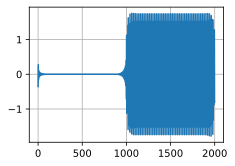

array([ 0.675,  5.95 , 12.575, 14.6  ])

In [3]:
# Signal Decomposition

Fs = 100
t = np.linspace(0, 4, 400, endpoint=False)

x1 = sine_wave(sampling_rate=Fs, frequency=5) + sine_wave(sampling_rate=Fs,frequency=10)
x2 = sine_wave(sampling_rate=Fs, frequency=1) + sine_wave(sampling_rate=Fs, frequency=15) + sine_wave(sampling_rate=Fs, frequency=20)

x = np.concatenate([x1, x2])


ewt_res, mfb ,boundaries = ewt(x, N=5, show=True)

boundaries / np.pi * Fs / 2


100%|██████████| 1/1 [00:00<00:00, 250.26it/s]

hr: 50 rr: 20 sp: 135 dp: 91


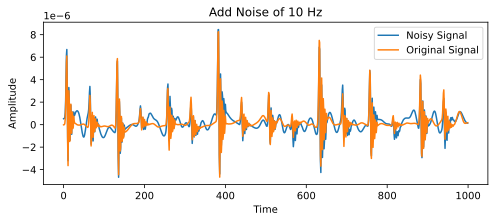

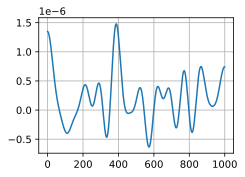

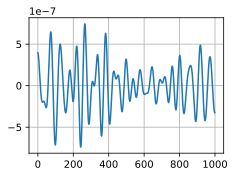

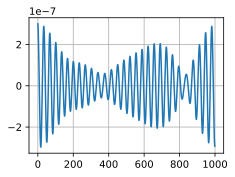

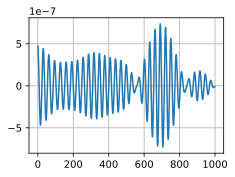

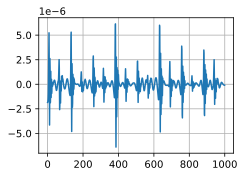

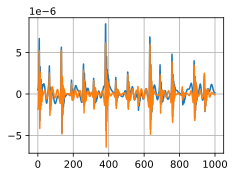

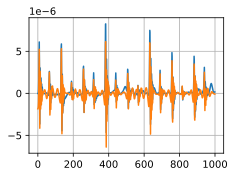

In [5]:
# 算是一种比较稳定的降噪手段

from NRSR_Tutorial.dsp import add_distort_noise, scg_simulate

scg_label = scg_simulate(n_echo = 0)
scg, label = scg_label[:1000], scg_label[-6:]

noisy_scg = add_distort_noise(scg, n_samples=1000, sampling_rate=100, noise_frequency=10,  noise_amplitude=0.5, show=True)

ewt_res, mfb ,boundaries = ewt(noisy_scg, N = 5, show=True)

plot([noisy_scg, ewt_res.T[-1]], show=True)
plot([scg, ewt_res.T[-1]], show=True)

100%|██████████| 1/1 [00:00<00:00, 250.03it/s]

hr: 69 rr: 18 sp: 120 dp: 71


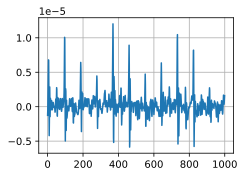

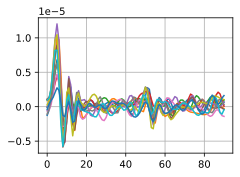

In [116]:
from NRSR_Tutorial.dsp import scg_simulate
from Core2dsp.SCG_Jiayu import segment_scg
from scipy.signal import find_peaks

scg_label = scg_simulate(n_echo = 0)
scg, label = scg_label[:1000], scg_label[-6:]
hr = int(label[2])

scg = add_distort_noise(scg, n_samples=1000, noise_frequency=35, noise_amplitude=0.5)


large_peaks, _ = find_peaks(scg, distance=5500//hr, height=np.mean(scg))

scg_pieces = segment_scg(scg, large_peaks)
plot(scg, show=True)
plot(scg_pieces, show=True)



In [117]:
U, S, Vh = np.linalg.svd(scg_pieces, full_matrices=False)
U.shape, S.shape, Vh.shape

((11, 11), (11,), (11, 91))

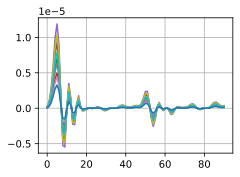

In [149]:
# SVD for Single Heartbeat Circle's Noise Reduction

N = 1
reconstructed_scg_pieces = np.dot(U[:, :N], np.dot(np.diag(S[:N]), Vh[:N]))

plot(reconstructed_scg_pieces)

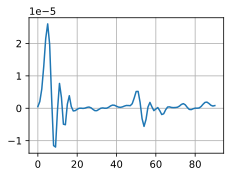

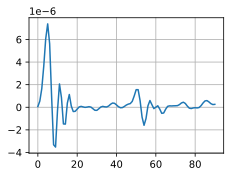

In [150]:
# SVD for Heartbeat Template Extraction
# scg(1000, 1) -> scg pieces (heartbeat_num, heartbeat_length), (n, m)
# n points in m-dim space
# we assume in short time (10s), every heartbeat is same
# so the rank of scg pieces matrix (n, m) should be 1, if there is no noise.
# since the scg pieces means the same heartbeat template repeats n times.
# scg_pieces * eg_vec = lambda * eg_vec
# choose the largest lambda's eg_vector, we can think it is template of 10s scg signal
# we can implement this by svd decomposition.


N = 1

reconstructed_scg_piece = np.dot(np.diag(S[:N]), Vh[:N])
# reconstructed_scg_piece = Vh[0]

plot(reconstructed_scg_piece, show=True)
plot(np.mean(scg_pieces, 0), show=True) # 实际上，这种方法和直接求平均的区别不是特别大，但却是非常有趣的一个视角